In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
"""
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')
"""

"\nurl = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'\noutput = 'data.zip'\ngdown.download(url, output, quiet=False)\ngdown.extractall('data.zip')\n"

In [5]:
def load_video(path: str) -> tf.Tensor:
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = tf.image.rgb_to_grayscale(frame)
        cropped = frame[190:236, 80:220, :]
        frames.append(cropped)

    cap.release()

    frames = tf.stack(frames)
    frames = tf.cast(frames, tf.float32)
    mean = tf.reduce_mean(frames)
    std = tf.math.reduce_std(frames)

    normalized = (frames - mean) / (std + 1e-6)
    return normalized


In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [10]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [13]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

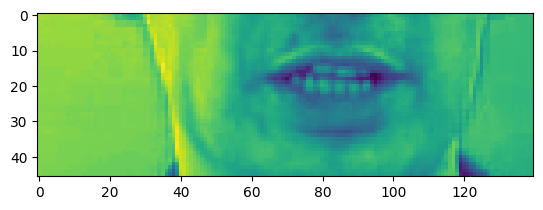

In [16]:
plt.imshow(frames[40])

In [17]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Data pipeline

In [20]:
from matplotlib import pyplot as plt

In [21]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [22]:
len(test)

50

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)

2

In [25]:
sample = data.as_numpy_iterator()

In [26]:
val = sample.next(); val[0]

array([[[[[ 1.4327282 ],
          [ 1.3151058 ],
          [ 1.1974835 ],
          ...,
          [ 0.25650492],
          [ 0.2172975 ],
          [ 0.2172975 ]],

         [[ 1.2758983 ],
          [ 1.4327282 ],
          [ 1.1190686 ],
          ...,
          [ 0.25650492],
          [ 0.2172975 ],
          [ 0.2172975 ]],

         [[ 1.6287653 ],
          [ 1.6287653 ],
          [ 1.4327282 ],
          ...,
          [ 0.29571238],
          [ 0.25650492],
          [ 0.25650492]],

         ...,

         [[ 1.0406537 ],
          [ 1.0406537 ],
          [ 1.0406537 ],
          ...,
          [-0.05715458],
          [-0.05715458],
          [-0.05715458]],

         [[ 1.0406537 ],
          [ 1.0406537 ],
          [ 1.0406537 ],
          ...,
          [-0.05715458],
          [-0.05715458],
          [-0.05715458]],

         [[ 1.0406537 ],
          [ 1.0406537 ],
          [ 1.0406537 ],
          ...,
          [-0.05715458],
          [-0.05715458],
          

In [27]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [-4.369973182678223, 2.1384620666503906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.566009998321533, 2.216876983642578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.6836323738098145, 2.2952919006347656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.644424915313721, 2.1776695251464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.644424915313721, 2.1776695251464844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.762047290802002, 2.216876983642578]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.722839832305908, 2.21687698364257

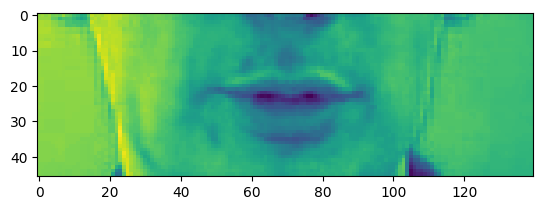

In [28]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d four now'>

3. Deep Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D , LSTM, Dense,Dropout ,Bidirectional,Activation,MaxPool3D,Reshape,SpatialDropout3D,TimeDistributed,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler

In [31]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [32]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(41,kernel_initializer='he_normal',activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [34]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [35]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'4444444444444444444444444444444444444444444444444444444444444444???????rrrr'>

In [36]:
model.input_shape

(None, 75, 46, 140, 1)

In [37]:
model.output.shape

TensorShape([None, 75, 41])

Setup Training

In [38]:
import tensorflow as tf

def CTCLoss(y_true, y_pred):
    # Get batch size
    batch_len = tf.shape(y_true)[0]

    # Get input and label lengths
    input_length = tf.fill([batch_len, 1], tf.shape(y_pred)[1])   # Time steps
    label_length = tf.fill([batch_len, 1], tf.shape(y_true)[1])   # Label length

    # Convert to int64 as required by ctc_batch_cost
    input_length = tf.cast(input_length, tf.int64)
    label_length = tf.cast(label_length, tf.int64)

    # Compute the CTC loss
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [39]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [40]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss=CTCLoss)

In [41]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoints'),monitor='loss',save_weights_only=True)

In [42]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [43]:
schedule_callback = LearningRateScheduler(scheduler)

In [44]:
example_callback = ProduceExample(data)

In [ ]:
£model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 1s 1s/steps - loss: 85.76
Original: lay red with f two please
Prediction: le e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by r zero please
Prediction: le e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 647s 1s/step - loss: 85.7615 - val_loss: 71.0086 - lr: 1.0000e-04
Epoch 2/100
195/450 [============>.................] - ETA: 3:14 - loss: 72.4580

KeyboardInterrupt: 